# Assignment 1, ECE9309 Machine Learning
> **Group 21**
> 
> B. Dudley, N. Mitchell, B. Shan, and E. Simpson


### Dependencies

In [1]:
import os
import warnings
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Global Parameters

In [2]:
# file paths
path_to_anomalies = "Datasets/Datasets/Experiments_with_Anomalies"
path_to_normal = "Datasets/Datasets/Normal_Experiments"

# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

# flags
flag_regen_merged_files = False

# tags
TAG_ANOMALY = "Anomaly_Tag"
TAG_EXPERIMENT = "HEAT_ID_01_ALARM_OUT_tag"

### Helper functions

In [3]:
# helper function to load all the files in a directory to a pandas dataframe (operation is the same for Q1 and Q2)
def load_df_from_directory(fp):
    list_of_files = os.listdir(fp)                     # get list of files in directory
    print("Found {} files in {}\n".format(str(len(list_of_files)), path_to_normal))
    
    data = []                                                      # empty list to store data

    for file in list_of_files:
        if ".csv" in file:                                         # made sure it's a csv
            df_this_chunk = pd.read_csv(fp + '/' + file)
            df_this_chunk["experiment"] = file[:-4]                # add column to df with experiment label ([:-4] strips .csv)
            data.append(df_this_chunk)                             # add dataframe to list of dfs

    return pd.concat(data)                                         # concatenate list into a single dataframe
                                                                   # note that this is much more efficient that
                                                                   # concatenating on each loop

# helper function to filter a dataframe for Sds_armed == 1 (operation is the same for Q1 and Q2)
def filter_df_for_sds_armed(df):
    return df[df["Sds_Armed"] == 1]           # select only rows where Sds_Armed == 1

## Question 1
>Filter all "Normal Experiments" by taking into account only active samples `SDS_Armed=1`, and then merge them in a new file named as `merged_exp_normal.csv`.  Write a script that performs this task and then indicate the number of examples of the merged dataset.

First, load all the normal experiment data into a single pandas dataframe.

In [4]:
df_normal_data = load_df_from_directory(path_to_normal)

r, c = df_normal_data.shape
print("Dataset has {} rows and {} columns.\n".format(r,c))            # sanity check
        
df_normal_data.head()                                                 # show dataset head

Found 68 files in Datasets/Datasets/Normal_Experiments

Dataset has 1074858 rows and 11 columns.



X1        X2        X3        X4       X5       X6      X7       X8  \
0  0.006286  0.011072  0.088714  0.036855  0.12677  0.22329  1.7891  0.74325   
1  0.008937  0.015274  0.119970  0.051323  0.18024  0.30803  2.4193  1.03500   
2  0.012156  0.019694  0.150640  0.064529  0.24514  0.39717  3.0379  1.30130   
3  0.015202  0.024273  0.179940  0.075763  0.30658  0.48950  3.6288  1.52790   
4  0.017572  0.028237  0.208750  0.087763  0.30470  0.48138  3.6888  1.55960   

   Sds_Armed  Anomaly_Tag            experiment  
0          0            0  HEAT_ID_01_ALARM_OUT  
1          0            0  HEAT_ID_01_ALARM_OUT  
2          0            0  HEAT_ID_01_ALARM_OUT  
3          0            0  HEAT_ID_01_ALARM_OUT  
4          0            0  HEAT_ID_01_ALARM_OUT

Now, select the rows where `sds_armed = 1`, and save to `merged_normal.csv`.

In [5]:
df_normal_data_filtered = filter_df_for_sds_armed(df_normal_data)        # select only rows where Sds_Armed == 1

if flag_regen_merged_files:                                              # save the files
    df_normal_data_filtered.reset_index(inplace=True, drop=True)
    df_normal_data_filtered.to_csv(file_name_normal)
    print("Dataframe saved to " + file_name_normal + "\n")

r, c = df_normal_data_filtered.shape                                     # sanity check
print("There are {} filtered samples.".format(r))

There are 152356 filtered samples.


## Question 2
>Filter all "Experiments with Anomalies" by taking into account only active samples `SDS_Armed=1` similar to the requirements in Question 1, and then, merge them in a new file named as `merged_exp_contains_anomalies.csv`.  Write a script that performs this task and then indicate the number of examples of the merged dataset.

First, load all the experiment data with anomalies into a single pandas dataframe.

In [6]:
df_anomalies_data = load_df_from_directory(path_to_anomalies)

r, c = df_anomalies_data.shape                                           # sanity check
print("Dataset has {} rows and {} columns.\n".format(r,c))
        
df_anomalies_data.head()

Found 19 files in Datasets/Datasets/Normal_Experiments

Dataset has 337678 rows and 11 columns.



X1       X2      X3      X4       X5      X6      X7      X8  \
0  0.013140  0.12678  12.542  11.555  0.26499  2.5567  252.93  233.02   
1  0.017626  0.19434  16.398  15.304  0.35545  3.9191  330.69  308.63   
2  0.023475  0.26901  21.088  23.897  0.47341  5.4251  425.28  481.91   
3  0.029957  0.32924  24.734  30.407  0.60412  6.6396  498.81  613.22   
4  0.035268  0.38214  30.263  35.762  0.62297  7.1138  556.19  669.09   

   Sds_Armed  Anomaly_Tag                experiment  
0          0            0  HEAT_ID_01_ALARM_OUT_tag  
1          0            0  HEAT_ID_01_ALARM_OUT_tag  
2          0            0  HEAT_ID_01_ALARM_OUT_tag  
3          0            0  HEAT_ID_01_ALARM_OUT_tag  
4          0            0  HEAT_ID_01_ALARM_OUT_tag

Now, select the rows where `sds_armed = 1`, and save to `merged_exp_contains_anomalies.csv`.

In [7]:
df_anomalies_data_filtered = filter_df_for_sds_armed(df_anomalies_data)        # select only rows where Sds_Armed == 1

if flag_regen_merged_files:                                                    # save the files
    df_anomalies_data_filtered.to_csv(file_name_anomalies)
    print("Dataframe saved to " + file_name_anomalies + "\n")

r, c = df_anomalies_data_filtered.shape                                        # sanity check
print("There are {} filtered samples.".format(r))

There are 45626 filtered samples.


## Question 3
>Since the merged_exp_contains_anomalies.csv contains anomalies, apply any significance test to rank the significance of each feature (X1, X2, ..., X8) as being a distinctive feature of
anomalies.

Start by loading data from the .csv file generated in Q2.

In [8]:
df_anomalies = pd.read_csv(file_name_anomalies, index_col = 0)
df_anomalies = df_anomalies.drop(columns=['Sds_Armed', 'experiment'])
df_anomalies.head()

X1      X2      X3      X4       X5      X6      X7      X8  \
745  1.7957  6.1964  508.57  875.40  0.43922  1.5473  57.021  56.914   
746  1.7851  6.1508  503.90  867.18  0.43947  1.3525  53.658  58.856   
747  1.7760  6.1173  499.62  860.56  0.42528  1.3391  52.551  69.101   
748  1.7641  6.0799  494.07  851.51  0.42802  1.3679  51.228  75.935   
749  1.7525  6.0333  486.73  840.86  0.40701  1.3128  47.228  72.784   

     Anomaly_Tag  
745            0  
746            0  
747            0  
748            0  
749            0

Calculate the correlation matrix for the `merged_exp_anomalies.csv` dataset.

What we're interested in is how strongly `Anomaly_Tag` is correlated with each feature [X1, ..., X8], so we're going to pull out the column `Anomaly_Tag` and sort it based on the absolute value.

The top values will correspond to the features that are most strongly correlated with anomalies.

In [9]:
corr_anomalies = df_anomalies.corr()                                 # calculate the correlation matrix
corr_anomalies["Anomaly_Tag"].abs().sort_values(ascending=False)     # print the sorted magnitudes of the anomaly_tag

Anomaly_Tag    1.000000
X1             0.368017
X5             0.323319
X6             0.152556
X8             0.069587
X2             0.063553
X3             0.051786
X4             0.039113
X7             0.010843
Name: Anomaly_Tag, dtype: float64

The features mostly strong correlated with the presence of an anomaly are **X1** and **X5**, and the least strongly correlated are X4 and X7.

## Question 4
>Model  the  normal  process  “mergedexpnormal.csv”  using  Gaussian  distribution. Assume that the features are independent. Consider all features (X1, X2, ..., X8). Mark  the  most  important  two  features  (obtained  from  the  significance  test  in  Question  3).

Load fresh data (without anomalies).

In [10]:
df_normal = pd.read_csv(file_name_normal, index_col = 0)
df_normal.drop(columns=['Sds_Armed','experiment'],inplace=True)
df_normal.head()

X1       X2      X3      X4       X5       X6      X7      X8  \
0  0.42051  0.73265  6.0160  1.4258  0.22390  0.44638  4.9892  1.3106   
1  0.41743  0.72691  6.0102  1.4259  0.21750  0.44326  5.0469  1.3243   
2  0.41608  0.72337  6.0093  1.4254  0.21875  0.44661  5.0830  1.3227   
3  0.41517  0.72154  6.0002  1.4261  0.23488  0.46345  4.9672  1.3509   
4  0.41376  0.71773  5.9814  1.4257  0.25363  0.48208  4.8346  1.3580   

   Anomaly_Tag  
0            0  
1            0  
2            0  
3            0  
4            0

To model all the X1 - X8 values using a guassian distribution. We will need mean and standard deviations of each feature.  Start with the standard deviation:

In [11]:
X_stds = df_normal.std(axis=0, numeric_only=True)
X_stds

X1              0.486957
X2              0.989620
X3             13.900517
X4              3.466298
X5              0.779838
X6              1.570947
X7             18.187955
X8              4.701613
Anomaly_Tag     0.000000
dtype: float64

Now the mean:

In [12]:
X_means = df_normal.mean(axis=0, numeric_only=True)
X_means

X1             0.497500
X2             0.883802
X3             7.763045
X4             2.617440
X5             0.477496
X6             0.849776
X7             7.395009
X8             2.546401
Anomaly_Tag    0.000000
dtype: float64

Now, with the mean and standard deviations calculated, we have the information we need to model each feature as a gaussian distribution.

We will mark X5 and X1 as the two most important features to determining the presence of an anomaly.

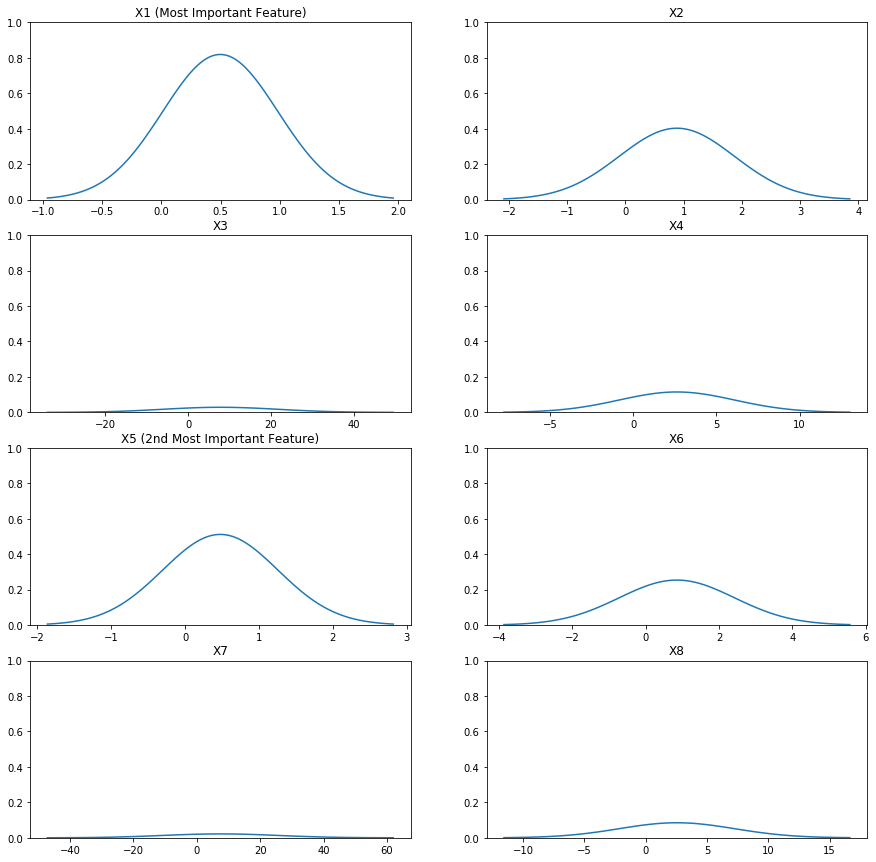

In [13]:
# hide mpl deprecation warnings
warnings.filterwarnings('ignore')

# flags
most_important = 1
secd_important = 5
flag_normalize_axes = True

# make plots
plt.subplots(4,2,figsize=(15,15))
for i in range(8):    
    # calculate normal dist to +/- 3 sigma
    x = np.linspace(X_means[i] - 3*X_stds[i], X_means[i] + 3*X_stds[i], 100)
    dist = stats.norm.pdf(x, X_means[i], X_stds[i])
    
    # calculate title
    title = 'X' + str(i+1)
    if i+1 == most_important: title += ' (Most Important Feature)'
    elif i+1 == secd_important: title += ' (2nd Most Important Feature)'
        
    # add subplot
    subplot = plt.subplot(4, 2, i+1, title=title)
    subplot.plot(x, dist)
    if flag_normalize_axes: subplot.set_ylim([0, 1]) 

####  PCA

> The  projection  of  the  feature  space  into  the  first  two  components  using  Principle  ComponentAnalysis (PCA) (obtained from the significance test in Question 3)

Start over with a fresh dataframe.

In [14]:
df_normal = pd.read_csv(file_name_normal, index_col = 0)
df_normal = df_normal.drop(columns=['Sds_Armed','experiment', 'Anomaly_Tag'])
df_normal.head()

X1       X2      X3      X4       X5       X6      X7      X8
0  0.42051  0.73265  6.0160  1.4258  0.22390  0.44638  4.9892  1.3106
1  0.41743  0.72691  6.0102  1.4259  0.21750  0.44326  5.0469  1.3243
2  0.41608  0.72337  6.0093  1.4254  0.21875  0.44661  5.0830  1.3227
3  0.41517  0.72154  6.0002  1.4261  0.23488  0.46345  4.9672  1.3509
4  0.41376  0.71773  5.9814  1.4257  0.25363  0.48208  4.8346  1.3580

Shift the dataset to have a zero mean.

In [15]:
df_normal = df_normal - df_normal.mean()
df_normal.mean() # calculate the new mean and print to verify ~= 0

X1   -4.190098e-15
X2   -3.549537e-15
X3    1.761940e-15
X4   -1.948893e-14
X5    4.167461e-15
X6   -4.997511e-15
X7    1.627771e-13
X8   -1.836548e-14
dtype: float64

Calculate the covariance matrix, Sx.

In [16]:
Sx = df_normal.cov()
Sx

X1        X2          X3         X4        X5         X6  \
X1  0.237127  0.469539    3.827697   1.283360  0.141805   0.280584   
X2  0.469539  0.979348    9.231350   2.875613  0.274458   0.581017   
X3  3.827697  9.231350  193.224368  42.086533  1.956296   5.183251   
X4  1.283360  2.875613   42.086533  12.015223  0.671428   1.567032   
X5  0.141805  0.274458    1.956296   0.671428  0.608147   1.190327   
X6  0.280584  0.581017    5.183251   1.567032  1.190327   2.467874   
X7  2.034031  5.073584  112.064358  22.959798  8.644799  19.680881   
X8  0.717838  1.619127   24.372733   6.651358  2.807354   6.138411   

            X7         X8  
X1    2.034031   0.717838  
X2    5.073584   1.619127  
X3  112.064358  24.372733  
X4   22.959798   6.651358  
X5    8.644799   2.807354  
X6   19.680881   6.138411  
X7  330.801704  75.317589  
X8   75.317589  22.105169

Now, find the eigenvectors and eigenvectors, V, and eigen values, D, of the covariance matrix.

In [17]:
D, V = LA.eig(Sx)
print('Eigenvalues:' + str(D))
print('Eigenvectors:')
pd.DataFrame(V) # convert to dataframe for nicer display

Eigenvalues:[4.14758996e+02 1.37993248e+02 6.45484378e+00 2.07594183e+00
 8.87676346e-01 2.39049685e-01 5.16631701e-03 2.40373917e-02]
Eigenvectors:


0         1         2         3         4         5         6  \
0  0.009267  0.017978 -0.082560  0.138688  0.164519  0.428886 -0.840929   
1  0.022562  0.042548 -0.154274  0.267035  0.294229  0.760702  0.468519   
2  0.473584  0.851522  0.095853 -0.201484  0.008310  0.027490 -0.002579   
3  0.101633  0.193426 -0.431515  0.800941 -0.086760 -0.341820 -0.012693   
4  0.021645 -0.019050 -0.162057 -0.099061  0.412028 -0.154966  0.237257   
5  0.049957 -0.038525 -0.311960 -0.207571  0.740480 -0.277322 -0.129760   
6  0.850689 -0.469001  0.204747  0.114811  0.033893 -0.010535 -0.000026   
7  0.195340 -0.116420 -0.780056 -0.401591 -0.399423  0.136965  0.005644   

          7  
0 -0.235306  
1  0.133507  
2 -0.003545  
3  0.003925  
4 -0.844405  
5  0.462125  
6 -0.001913  
7 -0.013996

Keep the two most important eigenvectors.

In [18]:
V = V[0:2]

Print the original data for comparison.

In [19]:
df_normal.head()

X1        X2        X3       X4        X5        X6        X7  \
0 -0.07699 -0.151152 -1.747045 -1.19164 -0.253596 -0.403396 -2.405809   
1 -0.08007 -0.156892 -1.752845 -1.19154 -0.259996 -0.406516 -2.348109   
2 -0.08142 -0.160432 -1.753745 -1.19204 -0.258746 -0.403166 -2.312009   
3 -0.08233 -0.162262 -1.762845 -1.19134 -0.242616 -0.386326 -2.427809   
4 -0.08374 -0.166072 -1.781645 -1.19174 -0.223866 -0.367696 -2.560409   

         X8  
0 -1.235801  
1 -1.222101  
2 -1.223701  
3 -1.195501  
4 -1.188401

Compute the final dataset reduced to the two principle components.

In [20]:
# this may take a bit
df_finalData = pd.DataFrame(df_normal.apply(lambda x: np.dot(V,x),
                                            axis = 1,
                                            result_type='expand'))
df_finalData

0          1
0       2.074712  -1.730490
1       2.020937  -1.705276
2       1.992527  -1.685836
3       2.093954  -1.717277
4       2.216281  -1.756167
...          ...        ...
152351 -8.215928  12.539380
152352 -8.722230  12.945086
152353 -8.703734  12.876947
152354 -8.641965  12.703050
152355 -7.840704  11.658171

[152356 rows x 2 columns]

## Question 5
>Model the same normal process “mergedexpnormal.csv” using Gaussian distribution with all requirements in Question 4.  However, assume that the features are dependent.

Start with a fresh dataframe.

In [21]:
df_normal = pd.read_csv(file_name_normal, index_col = 0)
df_normal = df_normal.drop(columns=['Sds_Armed','experiment', 'Anomaly_Tag']) # don't need these
df_normal.head()

X1       X2      X3      X4       X5       X6      X7      X8
0  0.42051  0.73265  6.0160  1.4258  0.22390  0.44638  4.9892  1.3106
1  0.41743  0.72691  6.0102  1.4259  0.21750  0.44326  5.0469  1.3243
2  0.41608  0.72337  6.0093  1.4254  0.21875  0.44661  5.0830  1.3227
3  0.41517  0.72154  6.0002  1.4261  0.23488  0.46345  4.9672  1.3509
4  0.41376  0.71773  5.9814  1.4257  0.25363  0.48208  4.8346  1.3580

To calculate the multi-variate gaussian we need to start with covariance matrix.

In [22]:
cov = df_normal.cov()
cov

X1        X2          X3         X4        X5         X6  \
X1  0.237127  0.469539    3.827697   1.283360  0.141805   0.280584   
X2  0.469539  0.979348    9.231350   2.875613  0.274458   0.581017   
X3  3.827697  9.231350  193.224368  42.086533  1.956296   5.183251   
X4  1.283360  2.875613   42.086533  12.015223  0.671428   1.567032   
X5  0.141805  0.274458    1.956296   0.671428  0.608147   1.190327   
X6  0.280584  0.581017    5.183251   1.567032  1.190327   2.467874   
X7  2.034031  5.073584  112.064358  22.959798  8.644799  19.680881   
X8  0.717838  1.619127   24.372733   6.651358  2.807354   6.138411   

            X7         X8  
X1    2.034031   0.717838  
X2    5.073584   1.619127  
X3  112.064358  24.372733  
X4   22.959798   6.651358  
X5    8.644799   2.807354  
X6   19.680881   6.138411  
X7  330.801704  75.317589  
X8   75.317589  22.105169

We also need the means.

In [23]:
means = df_normal.mean()
means

X1    0.497500
X2    0.883802
X3    7.763045
X4    2.617440
X5    0.477496
X6    0.849776
X7    7.395009
X8    2.546401
dtype: float64

Now, add a column to the dataframe showing the multivariate gaussian probability of the sample.

In [24]:
p = df_normal.apply(lambda x: stats.multivariate_normal.pdf(x.to_numpy(),
                                                            means.to_numpy(),
                                                            cov.to_numpy()), axis=1)
p.head()

0    0.000109
1    0.000108
2    0.000109
3    0.000111
4    0.000113
dtype: float64

In [25]:
p.describe()

count    152356.000000
mean          0.000090
std           0.000039
min           0.000000
25%           0.000077
50%           0.000103
75%           0.000118
max           0.000140
dtype: float64

## Question 6

>Develop an anomaly alarm by adjusting a threshold to your Gaussian models obtainedin Questions 3 and 4, and accordingly, generate an alarm accordingly. Use any experiment that contains anomaly as a test case.

Implement a function that takes as an input the sample, calculates p(x) for that sample, and returns the value p(x) < epsilon.

In [26]:
def apply_alarm(X, means, stds, epsilon):
    p = 1; # initialize p
    for i in range(0,len(X)):
        p *= stats.norm.pdf(X[i],means[i],stds[i])
    return p < epsilon

Next, write a simple test driver for the apply_alarm function that uses the features X1 and X5 (the most significant features as determined above) and applies the function to a single sample.

In [27]:
data = df_normal[['X1','X5']]      # only use features X1 and X5
means = data.mean()
stds = data.std()

epsilon = 0.1     # a random epsilon
apply_alarm(data.iloc[2], means, stds, epsilon)

False

Apply the alarm to one of the tests containing anomalous samples.

Load the dataset and filter test name.

Then, apply the test to each sample and classify as containing an anomaly or not.

Finally, generate some metrics (precision and recall) to evaluate the effectiveness of the model.

In [28]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment'] == TAG_EXPERIMENT] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_anomaly = df_anomaly[['X1', 'X5']]
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal = df_normal[['X1', 'X5']]

# means and stds for gaussian
means = df_normal.mean()
stds = df_normal.std()

# apply the alarm to the experiement
epsilon = 0.2
predicted_labels = df_anomaly.apply(lambda x: apply_alarm(x, means, stds, epsilon), axis=1)

# calculate # of true pos, fals pos, and fals neg
true_pos = np.sum(predicted_labels[true_labels==1]==1)
false_pos = np.sum(predicted_labels[true_labels == 0] == 1)
false_neg = np.sum(predicted_labels[true_labels == 1] == 0)

# calculate precision, recall, and f value
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
fvalue = (2*precision*recall)/(precision+recall)

# print metrics
print("Num of predicted pos: {}".format(np.sum(predicted_labels)))
print("Num of actual pos: {}".format(np.sum(true_labels)))
print("Num of predicted neg: {}".format(np.sum(predicted_labels == 0)))
print("Num of actual neg: {}".format(np.sum(true_labels == 0)))
print("True positives:  " + str(true_pos))
print("False positives: " + str(false_pos))
print("False negatives: " + str(false_neg) + '\n')
print("Precision: {}%".format(100*precision))
print("Recall: {}%".format(100*recall))
print("F-value: {}%".format(100*fvalue))

Num of predicted pos: 112
Num of actual pos: 406
Num of predicted neg: 2068
Num of actual neg: 1774
True positives:  44
False positives: 68
False negatives: 362

Precision: 39.285714285714285%
Recall: 10.83743842364532%
F-value: 16.988416988416986%


# Indepedent Gaussian x1-x8

In [29]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']== TAG_EXPERIMENT]

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about, leaving x1-x8
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# means and stds for gaussian
means = df_normal.mean()
stds = df_normal.std()
epsilon = 0.00000002

# apply the alarm to the experiement
predicted_labels = df_anomaly.apply(lambda x: apply_alarm(x, means, stds, epsilon), axis=1)

# calculate and display some performance stats
true_pos = np.sum(predicted_labels[true_labels==1]==1)
false_pos = np.sum(predicted_labels[true_labels == 0] == 1)
false_neg = np.sum(predicted_labels[true_labels == 1] == 0)
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
fvalue = (2*precision*recall)/(precision+recall)

# print metrics
print("Num of predicted pos: {}".format(np.sum(predicted_labels)))
print("Num of actual pos: {}".format(np.sum(true_labels)))
print("Num of predicted neg: {}".format(np.sum(predicted_labels == 0)))
print("Num of actual neg: {}".format(np.sum(true_labels == 0)))
print("True positives: " + str(true_pos))
print("False positives: " + str(false_pos))
print("False Negatives: " + str(false_neg) + '\n')
print("Precision: {}%".format(100*precision))
print("Recall: {}%".format(100*recall))
print("F-value: {}%".format(100*fvalue))

Num of predicted pos: 721
Num of actual pos: 406
Num of predicted neg: 1459
Num of actual neg: 1774
True positives: 279
False positives: 442
False Negatives: 127

Precision: 38.69625520110957%
Recall: 68.7192118226601%
F-value: 49.51197870452528%


# Dependent Gaussian x1-x8

In [30]:
experiment = 'HEAT_ID_01_ALARM_OUT_tag' # experiment to use

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)
# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# calculate the covariance matrix 
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
means = df_normal.mean()
cov = df_normal.cov()

# find the probability of all the new values 
pAnom = df_anomaly.apply(lambda x: stats.multivariate_normal.pdf(x.to_numpy(),
                                                            means.to_numpy(),
                                                            cov.to_numpy()), axis=1)
pAnom = pd.DataFrame({'Prob': pAnom})

In [31]:
epsilon = 0.000077
# make the predicition based on epsilon 
pAnom['PredictedTag'] = np.where(pAnom['Prob']<=epsilon, 1, 0)

In [32]:
Confusion = confusion_matrix(true_labels, pAnom['PredictedTag'])
F1Score = f1_score(true_labels,pAnom['PredictedTag'],"macro")
precision = precision_score(true_labels,pAnom['PredictedTag'])
recall = recall_score(true_labels,pAnom['PredictedTag'])

TN = Confusion[0][0]
FN = Confusion[1][0]
TP = Confusion[1][1]
FP = Confusion[0][1]

print("True Negative = " +str(TN))
print("False Negative = " +str(FN))
print("True Positive = " +str(TP))
print("False Positive = " +str(FP))
print("F1 score (Dice) = "+str(F1Score))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

True Negative = 739
False Negative = 0
True Positive = 406
False Positive = 1035
F1 score (Dice) = 0.439631835408771
Precision = 0.2817487855655795
Recall = 1.0


## Question 7
>Plot the generated alarm, true anomaly flags (given from the dataset), and the feature X1.

Generate a one dimensional plot of each sample's X1 value.  Then, plot the true anomaly flags and the alarm flags generated in question 6.

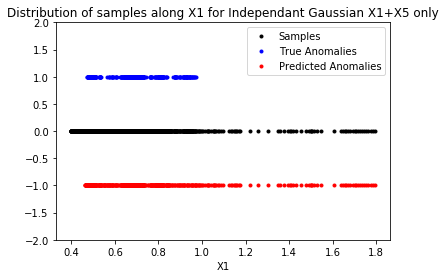

In [33]:
x1 = df_anomaly['X1']
x1_true = x1[true_labels == 1]
x1_predicted = x1[predicted_labels == 1]

line_sep = 1.0 # for plotting clarity

plt.plot(x1, np.zeros_like(x1), '.k')
plt.plot(x1_true, np.zeros_like(x1_true) + line_sep, '.b')
plt.plot(x1_predicted, np.zeros_like(x1_predicted) - line_sep, '.r')
plt.title("Distribution of samples along X1 for Independant Gaussian X1+X5 only")
plt.xlabel("X1")
plt.ylim(-2,2)
plt.legend(['Samples','True Anomalies','Predicted Anomalies'])
plt.show()

## Question 8
> Apply one supervised learning approach for classifying the events to normal and anomalies

Lets apply a linear classifier from the SKLearn package.

In [34]:
# load a fresh dataset (containing anomalies)
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select using experiment tag
df_anomaly_test = df_anomaly[df_anomaly['experiment'] == TAG_EXPERIMENT]
df_anomaly_train = df_anomaly[df_anomaly['experiment'] != TAG_EXPERIMENT]

# split into a training and test dataset by setting aside an experiment as test data
X_train = df_anomaly_train[['X1','X2','X3','X4','X5','X6','X7','X8']]
Y_train = df_anomaly_train['Anomaly_Tag']
X_test = df_anomaly_test[['X1','X2','X3','X4','X5','X6','X7','X8']]
Y_test = df_anomaly_test['Anomaly_Tag']

Define and train and linear classifier.

In [35]:
# code is based on the sklearn sgdclassifier documentation example available here:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss='log')
clf.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Use the trained classifier to make predictions on the test set, and generate some evaluation metrics.

In [36]:
Y_predict = clf.predict(X_test)

# calculate # of true pos, fals pos, and fals neg
true_pos = np.sum(Y_predict[Y_test == 1] == 1)
false_pos = np.sum(Y_predict[Y_test == 0] == 1)
false_neg = np.sum(Y_predict[Y_test == 1] == 0)

# calculate precision, recall, and f value
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
fvalue = (2*precision*recall)/(precision+recall)

# print metrics
print("Num of predicted pos: {}".format(np.sum(Y_predict)))
print("Num of actual pos: {}".format(np.sum(Y_test)))
print("Num of predicted neg: {}".format(np.sum(Y_predict == 0)))
print("Num of actual neg: {}".format(np.sum(Y_test == 0)))
print("True positives:  " + str(true_pos))
print("False positives: " + str(false_pos))
print("False negatives: " + str(false_neg) + '\n')
print("Precision: {}%".format(100*precision))
print("Recall: {}%".format(100*recall))
print("F-value: {}%".format(100*fvalue))

Num of predicted pos: 109
Num of actual pos: 406
Num of predicted neg: 2071
Num of actual neg: 1774
True positives:  52
False positives: 57
False negatives: 354

Precision: 47.706422018348626%
Recall: 12.807881773399016%
F-value: 20.19417475728155%


## Question 9
> Apply any clustering based algorithm you learn in the class, i.e., (hard and soft clusteringwith K-means, EM, ..., etc.)  to decouple the anomaly data from the normal ones.  Is there a direct mapping to the true anomaly tags?  discuss your findings

In [37]:
# load a fresh dataset (containing anomalies)
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select using experiment tag
df_anomaly_test = df_anomaly[df_anomaly['experiment'] == TAG_EXPERIMENT]
df_anomaly_train = df_anomaly[df_anomaly['experiment'] != TAG_EXPERIMENT]

# split into a training and test dataset by setting aside an experiment as test data
X_train = df_anomaly_train[['X1','X2','X3','X4','X5','X6','X7','X8']]
Y_train = df_anomaly_train['Anomaly_Tag']
X_test = df_anomaly_test[['X1','X2','X3','X4','X5','X6','X7','X8']]
Y_test = df_anomaly_test['Anomaly_Tag']

# code is based on the sklearn k-means documentation example available here:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
Y_predict = kmeans.predict(X_test)
print("Cluster centers: " + str(kmeans.cluster_centers_))

# calculate # of true pos, fals pos, and fals neg
true_pos = np.sum(Y_predict[Y_test == 1] == 1)
false_pos = np.sum(Y_predict[Y_test == 0] == 1)
false_neg = np.sum(Y_predict[Y_test == 1] == 0)

# calculate precision, recall, and f value
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
fvalue = (2*precision*recall)/(precision+recall)

# print metrics
print("Num of predicted pos: {}".format(np.sum(Y_predict)))
print("Num of actual pos: {}".format(np.sum(Y_test)))
print("Num of predicted neg: {}".format(np.sum(Y_predict == 0)))
print("Num of actual neg: {}".format(np.sum(Y_test == 0)))
print("True positives:  " + str(true_pos))
print("False positives: " + str(false_pos))
print("False negatives: " + str(false_neg) + '\n')
print("Precision: {}%".format(100*precision))
print("Recall: {}%".format(100*recall))
print("F-value: {}%".format(100*fvalue))

Cluster centers: [[  0.63162399   1.75480509  17.91107324   4.72092901   0.61847631
    1.66974165  17.07047076   3.85793435]
 [  0.84066979   6.33749834 385.91333529 404.02615738   0.48166254
    1.29112889  24.40715386   5.39184536]]
Num of predicted pos: 198
Num of actual pos: 406
Num of predicted neg: 1982
Num of actual neg: 1774
True positives:  57
False positives: 141
False negatives: 349

Precision: 28.78787878787879%
Recall: 14.039408866995073%
F-value: 18.874172185430464%


The results of the k-means clustering algorithm suggests that the there is no direct statistical mapping from cluster to anomaly tag.  This fits with the poor results from the statistical anomaly detection alarm implemented in Q6, the linear classifier in question 8, and now the poor results from K-means clustering.

Recall from Q3 that the feature most strongly correlated with an anomaly tag was X1.  Yet, the plot generated in Q7 shows that even in X1 there is poor separation in the anomalous tags from the rest of the dataset.

More advanced techniques may be required

## Question 10
> Compare the Gaussian-based anomaly detection algorithm, the supervised learning approach you picked, and the clustering approach.


### Detection Capabilities
| Phase | Independant Gaussian (x1+X5) | Independant Gaussian (xAll) | Multivariate Gaussian | Supervised learning (SGD linear classifier) | Clustering approach (K-means) |
| --- | --- | --- | --- | --- | --- |
| Precision | 39.28% | 38.69% | 28.17% | 47.44% | 28.79% |
| Recall | 10.84% | 68.71% | 100% | 9.11% | 14.04% |
| F-value |  16.9% | 49.51% | 43.96% | 15.2% | 18.9% | 


### Time Complexity

**Independant Gaussian**
- **Training:** The training phase of the independent gaussian, as part of Q4, consists of calculating the standard deviation and mean of the normal dataset. This results in an iteration over each data point in the set. O(n)
- **Execution:** The execution phase takes the mean and standard deviation of each feature space from normal data set, and applying that to the anomaly dataset. This results in an iteration over each data point in the set. O(n)

**Multivariate Gaussian**
- **Training:** the initial time cost comes from the calculation of the inverse of the covariance matrix (Q5). O(n^3)
- **Execution:** The time complexity during the execution phase is smaller than training phase. The inverse of the covariance matrix for normal dataset is used(already found) to in the probability density function via matrix multiplication. O(n^2)

**Supervised learning (SGD linear classifier)**
- **Training:** The approached used for the supervised learning model was a stochastic gradient descent linear classifier, specifically a logistic regression model. The time complexity of the training is a factor of the matrix input (size n by m) and the number of iterations (i). O(inm)
- **Execution:** The exexution of the linear classifier would be iterating through a list, while comparing a criteria in order to sort the values into a binary 1 or 0 output. The time complexity of this is depedant on the size of the matrix input (n by m). O(nm)  

**Clustering approach (K-means)**
- **Training:** Clusters are initially randomly assigned. All samples are then iterated over to calculate euclidean distance and assign respective clusters. This is done over a data-set with n data-points, each with m attributes. It is iterated over I iterations for k clusters. In our implementation max-iterations was set to 300 (I=300), and we used 2 clusters (k=2). Time complexity is then I * k * m * n, which evaluates at maximum iteration to 300 * 2 * m * n. O(Ikmn)
- **Execution:** For execution, a new point's euclidean distance is calculated to each cluster centroid, it is assigned a cluster, and that cluster's centroid is re-calculated. O(n)


### Time Complexity Big O notation
| Phase | Independant Gaussian  | Multivariate Gaussian | Supervised learning (SGD linear classifier) | Clustering approach (K-means) |
| --- | --- | --- | --- | --- |
| Training  | O(n) | O(n^3) | O(n) | O(n) |
| Execution | O(n) | O(n^3) | O(n) | O(n) |


### Memory Requirements

**Independant Gaussian**
- **Training:** The standard deviation and mean of hte noraml dataset is required, therefore 2 values for each feature "f" is required. In our case, there are 8 features so 16 memory locations are required. O(1).
- **Execution:** During execution the probability for n data-points is required to be stored in memory. Therefore we require n locations in memory. O(n).

**Multivariate Gaussian**
- **Training:** A covariance matrix, inverse covariance matrix, and mean vector are required. For n data-points, the matricies would be of size n^2 the mean vector is a 1-dimensional vector of size n. O(n^2)
- **Execution:** Only the inverse covariance is required to be stored in memory. For n data-points it is of size n^2. O(n^2)

**Supervised learning (SGD linear classifier)**
- **Training:** For n data-points a memory location is required to store it's computed probability. O(n)
- **Execution:** During execution only one data-point is required to store the final result of the descent. As the data from generated from training can be streamed from memory. O(1)

**Clustering approach (K-means)**
- **Training:** Memory is used to track the data point's assigned cluster, as well as the cluster centroid. O(n).
- **Execution:** For execution, memory is used to hold the current minumum euclidean distance, as well as the point's assigned cluster, and the new cluster centroids. O(n)


### Summary
In summary, we tested 5 different algorithms: Independent gaussian model with the 2 most important features (X2+X5), Independent gaussian with all features, dependent gaussian with all features, logistic regression and k-means clustering with k =2. It is clear to see that the logistic regression was able to detect the most anomalies, likewise it also had a very high number of false positives. This would not be ideal in a real scenario because the application is most likely very sensitive to false positives. On the contrary the multivariate gaussian performed well in terms of never having a false negative, however it still had many false positives. The Independent gaussian with the 2 most important variables had less memory time requirements because of smaller matrix multiplication math, however it let through a lot more false negatives and didn't detect anomalies when needed to. The Independent gaussian with all the x values performed the best in terms of F-score (dice coefficient). therefore had a more balanced value of precision and recall. In other words it didn't excel in any category but did decent in both. The final method tested was K-means clustering with a value of k=2. It was not able to accurately capture the anomalies, however it was able to do so faster than most approaches with less memory.